# Robust Speech Recognition via Large-Scale Weak Supervision (Whisper)

The Whisper architecture is a simple end-to-end approach, implemented as an encoder-decoder Transformer. Input audio is split into 30-second chunks, converted into a log-Mel spectrogram, and then passed into an encoder. A decoder is trained to predict the corresponding text caption, intermixed with special tokens that direct the single model to perform tasks such as language identification, phrase-level timestamps, multilingual speech transcription, and to-English speech translation.

<img src="figures/whisper-arch.png" title="Whisper Framework" style="width: 640px;" />

In [1]:
# pip install evaluate
# pip install torchaudio
# pip install transformers
# pip install numpy
# pip install tqdm

In [2]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
import os
import time
import numpy as np
from tqdm.auto import tqdm

import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from subprocess import CalledProcessError, run
from typing import Optional, Union, Dict, Iterable, Optional

device = "cuda" if torch.cuda.is_available() else "cpu"

## Log-Mel spectrogram

A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing and machine learning tasks. It is similar to a spectrogram in that it shows the frequency content of an audio signal over time, but on a different frequency axis.

In [4]:
def exact_div(x, y):
    assert x % y == 0
    return x // y

In [5]:
# hard-coded audio hyperparameters
SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = 160
CHUNK_LENGTH = 30
N_SAMPLES = CHUNK_LENGTH * SAMPLE_RATE  # 480000 samples in a 30-second chunk
N_FRAMES = exact_div(N_SAMPLES, HOP_LENGTH)  # 3000 frames in a mel spectrogram input

N_SAMPLES_PER_TOKEN = HOP_LENGTH * 2  # the initial convolutions has stride 2
FRAMES_PER_SECOND = exact_div(SAMPLE_RATE, HOP_LENGTH)  # 10ms per audio frame
TOKENS_PER_SECOND = exact_div(SAMPLE_RATE, N_SAMPLES_PER_TOKEN)  # 20ms per audio token

In [6]:
# This launches a subprocess to decode audio while down-mixing
# and resampling as necessary.  Requires the ffmpeg CLI in PATH.
# fmt: off
    
def load_audio(file: str, sr: int = SAMPLE_RATE):
    cmd = [
        "ffmpeg",
        "-nostdin",
        "-threads", "0",
        "-i", file,
        "-f", "s16le",
        "-ac", "1",
        "-acodec", "pcm_s16le",
        "-ar", str(sr),
        "-"
    ]
    # fmt: on
    try:
        out = run(cmd, capture_output=True, check=True).stdout
    except CalledProcessError as e:
        raise RuntimeError(f"Failed to load audio: {e.stderr.decode()}") from e

    return np.frombuffer(out, np.int16).flatten().astype(np.float32) / 32768.0

In [7]:
__file__ = ''

def pad_or_trim(array, length: int = N_SAMPLES, *, axis: int = -1):
    """
    Pad or trim the audio array to N_SAMPLES, as expected by the encoder.
    """
    if torch.is_tensor(array):
        if array.shape[axis] > length:
            array = array.index_select(
                dim=axis, index=torch.arange(length, device=array.device)
            )

        if array.shape[axis] < length:
            pad_widths = [(0, 0)] * array.ndim
            pad_widths[axis] = (0, length - array.shape[axis])
            array = F.pad(array, [pad for sizes in pad_widths[::-1] for pad in sizes])
    else:
        if array.shape[axis] > length:
            array = array.take(indices=range(length), axis=axis)

        if array.shape[axis] < length:
            pad_widths = [(0, 0)] * array.ndim
            pad_widths[axis] = (0, length - array.shape[axis])
            array = np.pad(array, pad_widths)

    return array

def mel_filters(device, n_mels: int) -> torch.Tensor:
    """
    load the mel filterbank matrix for projecting STFT into a Mel spectrogram.
    Allows decoupling librosa dependency; saved using:

        np.savez_compressed(
            "mel_filters.npz",
            mel_80=librosa.filters.mel(sr=16000, n_fft=400, n_mels=80),
            mel_128=librosa.filters.mel(sr=16000, n_fft=400, n_mels=128),
        )
    """
    assert n_mels in {80, 128}, f"Unsupported n_mels: {n_mels}"

    filters_path = os.path.join(os.path.dirname(__file__), "assets", "mel_filters.npz")
    with np.load(filters_path, allow_pickle=False) as f:
        return torch.from_numpy(f[f"mel_{n_mels}"]).to(device)
    
# Compute the log-Mel spectrogram of
def log_mel_spectrogram(
    audio: Union[str, np.ndarray, torch.Tensor],
    n_mels: int = 80,
    padding: int = 0,
    device: Optional[Union[str, torch.device]] = None,
):
    if not torch.is_tensor(audio):
        if isinstance(audio, str):
            audio = load_audio(audio)
        audio = torch.from_numpy(audio)

    if device is not None:
        audio = audio.to(device)
    if padding > 0:
        audio = F.pad(audio, (0, padding))
    window = torch.hann_window(N_FFT).to(audio.device)
    stft = torch.stft(audio, N_FFT, HOP_LENGTH, window=window, return_complex=True)
    magnitudes = stft[..., :-1].abs() ** 2

    filters = mel_filters(audio.device, n_mels)
    mel_spec = filters @ magnitudes

    log_spec = torch.clamp(mel_spec, min=1e-10).log10()
    log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
    log_spec = (log_spec + 4.0) / 4.0
    
    return log_spec # torch.Tensor, shape = (80, n_frames)

In [8]:
# load audio and pad/trim it to fit 30 seconds
audio = load_audio("audio.mp3") #(96597,)
audio = pad_or_trim(audio) #(480000,)

In [9]:
# make log-Mel spectrogram and move to the same device as the model
mel = log_mel_spectrogram(audio)
mel.shape #torch.Size([80, 3000])

torch.Size([80, 3000])

## Dataset

In [10]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()
common_voice["train"] = load_dataset(
    "mozilla-foundation/common_voice_11_0", "th", 
    split="train+validation", 
    # use_auth_token=True
)
common_voice["test"] = load_dataset(
    "mozilla-foundation/common_voice_11_0", "th", 
    split="test", 
    # use_auth_token=True
)
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
common_voice

Found cached dataset common_voice_11_0 (/home/todsavadt/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/th/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631)
Found cached dataset common_voice_11_0 (/home/todsavadt/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/th/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631)


DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 42779
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 10930
    })
})

### Load WhisperFeatureExtractor
- Padding and spectrogram conversion are both handled by the Transformers Whisper feature extractor in a single line of code! 
- To prepare for our audio data, let’s now load the feature extractor from the pre-trained checkpoint

In [11]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

### Load WhisperTokenizer

In [12]:
from transformers import WhisperTokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny", language="Thai",  task="transcribe")

In [13]:
# input_str = common_voice["train"][0]["sentence"]
# labels = tokenizer(input_str).input_ids
# decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
# decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

# print(f"Input:                 {input_str}")
# print(f"Decoded w/ special:    {decoded_with_special}")
# print(f"Decoded w/out special: {decoded_str}")
# print(f"Are equal:             {input_str == decoded_str}")

### Combine To Create A WhisperProcessor

We can combine the tokenizer and feature extractor into a single WhisperProcessor class to make using them easier. 
This processor object can be applied to audio inputs and model predictions as necessary and derives from the WhisperFeatureExtractor and WhisperProcessor.

In [14]:
from transformers import WhisperProcessor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny", language="Thai",  task="transcribe")

## Prepare Data

Now we can write a function to prepare our data ready for the model:

1. Using the batch[audio] function, we load and resample the audio data. Datasets, as previously mentioned, carry out any necessary resampling operations in real time.
2. From our 1-dimensional audio array, we compute the log-Mel spectrogram input features using the feature extractor.
3. Using the tokenizer, we encode the transcriptions to create label ids.

In [15]:
def prepare_dataset(examples):
    # compute log-Mel input features from input audio array
    audio = examples["audio"]
    examples["input_features"] = feature_extractor(audio["array"], sampling_rate=16000).input_features[0]

    del examples["audio"]
    sentences = examples["sentence"]

    # encode target text to label ids
    examples["labels"] = tokenizer(sentences).input_ids
    del examples["sentence"]

    return examples

In [16]:
train_dataset_ = common_voice['train'].shuffle(seed=55).select(list(range(1000)))
test_dataset_  = common_voice['test'].shuffle(seed=55).select(list(range(100)))

Loading cached shuffled indices for dataset at /home/todsavadt/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/th/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631/cache-4e725f4090f2c033.arrow
Loading cached shuffled indices for dataset at /home/todsavadt/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/th/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631/cache-b5ea01e9bfcfb160.arrow


In [18]:
train_dataset = train_dataset_.map(prepare_dataset)
test_dataset  = test_dataset_.map(prepare_dataset)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [19]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        # replace padding with -100 to ignore loss correctly
        # labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), tokenizer.pad_token_id)
        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]
        batch["labels"] = labels
        return batch

## initiate the data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## Dataloader

Create train, val, and test dataloaders

In [20]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
eval_dataloader  = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

## Architecture

<img src="figures/asr-summary-of-model-architecture-desktop.svg" title="Whisper Framework" style="width: 640px;" />

In [21]:
class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class Linear(nn.Linear):
    def forward(self, x):
        return F.linear(x, self.weight.to(x.dtype), None if self.bias is None else self.bias.to(x.dtype),)

class Conv1d(nn.Conv1d):
    def _conv_forward(self, x, weight, bias):
        return super()._conv_forward(x, weight.to(x.dtype), None if bias is None else bias.to(x.dtype))

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_state, n_head):
        super().__init__()
        self.n_head = n_head
        self.query  = Linear(n_state, n_state)
        self.key    = Linear(n_state, n_state, bias=False)
        self.value  = Linear(n_state, n_state)
        self.out    = Linear(n_state, n_state)

    def forward(self, x, xa = None, mask = None, kv_cache  = None, ):
        q = self.query(x)
        if kv_cache is None or xa is None or self.key not in kv_cache:
            # hooks, if installed (i.e. kv_cache is not None), will prepend the cached kv tensors;
            # otherwise, perform key/value projections for self- or cross-attention as usual.
            k = self.key(x if xa is None else xa)
            v = self.value(x if xa is None else xa)
        else:
            # for cross-attention, calculate keys and values once and reuse in subsequent calls.
            k = kv_cache[self.key]
            v = kv_cache[self.value]

        wv, qk = self.qkv_attention(q, k, v, mask)
        return self.out(wv), qk

    def qkv_attention(self, q , k , v , mask = None):
        n_batch, n_ctx, n_state = q.shape
        scale = (n_state // self.n_head) ** -0.25
        q = q.view(*q.shape[:2], self.n_head, -1).permute(0, 2, 1, 3) * scale
        k = k.view(*k.shape[:2], self.n_head, -1).permute(0, 2, 3, 1) * scale
        v = v.view(*v.shape[:2], self.n_head, -1).permute(0, 2, 1, 3)

        qk = q @ k
        if mask is not None:
            qk = qk + mask[:n_ctx, :n_ctx]
        qk = qk.float()
        w = F.softmax(qk, dim=-1).to(q.dtype)
        return (w @ v).permute(0, 2, 1, 3).flatten(start_dim=2), qk.detach()

In [23]:
class ResidualAttentionBlock(nn.Module):
    def __init__(self, n_state, n_head, cross_attention = False):
        super().__init__()

        self.attn = MultiHeadAttention(n_state, n_head)
        self.attn_ln = LayerNorm(n_state)

        self.cross_attn = (
            MultiHeadAttention(n_state, n_head) if cross_attention else None
        )
        self.cross_attn_ln = LayerNorm(n_state) if cross_attention else None

        n_mlp = n_state * 4
        self.mlp = nn.Sequential(
            Linear(n_state, n_mlp), nn.GELU(), Linear(n_mlp, n_state)
        )
        self.mlp_ln = LayerNorm(n_state)

    def forward(self, x, xa = None, mask = None, kv_cache = None,):
        x = x + self.attn(self.attn_ln(x), mask=mask, kv_cache=kv_cache)[0]
        if self.cross_attn:
            x = x + self.cross_attn(self.cross_attn_ln(x), xa, kv_cache=kv_cache)[0]
        x = x + self.mlp(self.mlp_ln(x))
        return x

In [24]:
class AudioEncoder(nn.Module):
    def __init__(
        self, n_mels: int, n_ctx: int, n_state: int, n_head: int, n_layer: int
    ):
        super().__init__()
        self.conv1 = Conv1d(n_mels, n_state, kernel_size=3, padding=1)
        self.conv2 = Conv1d(n_state, n_state, kernel_size=3, stride=2, padding=1)
        self.register_buffer("positional_embedding", sinusoids(n_ctx, n_state))

        self.blocks: Iterable[ResidualAttentionBlock] = nn.ModuleList(
            [ResidualAttentionBlock(n_state, n_head) for _ in range(n_layer)]
        )
        self.ln_post = LayerNorm(n_state)

    def forward(self, x):
        #x : torch.Tensor, shape = (batch_size, n_mels, n_ctx) the mel spectrogram of the audio
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = x.permute(0, 2, 1)

        assert x.shape[1:] == self.positional_embedding.shape, "incorrect audio shape"
        x = (x + self.positional_embedding).to(x.dtype)

        for block in self.blocks:
            x = block(x)

        x = self.ln_post(x)
        return x

In [25]:
class TextDecoder(nn.Module):
    def __init__(self, n_vocab, n_ctx, n_state, n_head, n_layer):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_state)
        self.positional_embedding = nn.Parameter(torch.empty(n_ctx, n_state))

        self.blocks: Iterable[ResidualAttentionBlock] = nn.ModuleList(
            [
                ResidualAttentionBlock(n_state, n_head, cross_attention=True)
                for _ in range(n_layer)
            ]
        )
        self.ln = LayerNorm(n_state)

        mask = torch.empty(n_ctx, n_ctx).fill_(-np.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)

    def forward(self, x, xa, kv_cache = None):
        # x = (batch_size, <= n_ctx)
        # xa = (batch_size, n_audio_ctx, n_audio_state)  
        offset = next(iter(kv_cache.values())).shape[1] if kv_cache else 0
        x = (
            self.token_embedding(x)
            + self.positional_embedding[offset : offset + x.shape[-1]]
        )
        x = x.to(xa.dtype)

        for block in self.blocks:
            x = block(x, xa, mask=self.mask, kv_cache=kv_cache)

        x = self.ln(x)
        logits = (x @ torch.transpose(self.token_embedding.weight.to(x.dtype), 0, 1)).float()
        
        return logits


In [26]:
import base64
import gzip
from dataclasses import dataclass
from typing import Dict, Iterable, Optional

@dataclass
class ModelDimensions:
    n_mels: int
    n_audio_ctx: int
    n_audio_state: int
    n_audio_head: int
    n_audio_layer: int
    n_vocab: int
    n_text_ctx: int
    n_text_state: int
    n_text_head: int
    n_text_layer: int

In [27]:
class Whisper(nn.Module):
    def __init__(self, dims: ModelDimensions):
        super().__init__()
        self.dims = dims
        self.encoder = AudioEncoder(
            self.dims.n_mels,
            self.dims.n_audio_ctx,
            self.dims.n_audio_state,
            self.dims.n_audio_head,
            self.dims.n_audio_layer,
        )
        self.decoder = TextDecoder(
            self.dims.n_vocab,
            self.dims.n_text_ctx,
            self.dims.n_text_state,
            self.dims.n_text_head,
            self.dims.n_text_layer,
        )
        # use the last half among the decoder layers for time alignment by default;
        # to use a specific set of heads, see `set_alignment_heads()` below.
        all_heads = torch.zeros(
            self.dims.n_text_layer, self.dims.n_text_head, dtype=torch.bool
        )
        all_heads[self.dims.n_text_layer // 2 :] = True
        self.register_buffer("alignment_heads", all_heads.to_sparse(), persistent=False)

    def embed_audio(self, mel):
        return self.encoder(mel)

    def logits(self, tokens, audio_features):
        return self.decoder(tokens, audio_features)

    def forward(self, mel, tokens):
        audio_encoder = self.encoder(mel)
        text_decoder  = self.decoder(tokens, audio_encoder)
        return text_decoder

In [28]:
dims = ModelDimensions(
    n_mels=80, 
    n_audio_ctx=1500, 
    n_audio_state=384, 
    n_audio_head=6, 
    n_audio_layer=4, 
    n_vocab=51865, 
    n_text_ctx=448, 
    n_text_state=384, 
    n_text_head=6, 
    n_text_layer=4)

In [29]:
model = Whisper(dims)
model.to(device)

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-3): 4 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=False)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (out): Linear(in_features=384, out_features=384, bias=True)
        )
        (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((384,), eps=1e-05,

In [30]:
import whisper
model_openai = whisper.load_model("tiny")

/home/todsavadt/.local/lib/python3.10/site-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [31]:
model.decoder.token_embedding = model_openai.decoder.token_embedding

In [32]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

 92160
   384
442368
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
   384
   384
172032
19916160
147456
   384
147456
147456
   384
147456
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
147456
   384
147456
147456
   384
147456
   384
   384
   384
589824
  1536
589824
   384
   384
   384
147456
   384
1474

In [33]:
for batch in train_dataloader:
    break

batch['input_features'].shape, batch['labels'].shape

(torch.Size([16, 80, 3000]), torch.Size([16, 42]))

In [34]:
logits = model(batch['input_features'].to(device), batch['labels'].to(device))
logits.shape

torch.Size([16, 42, 51865])

## How to train

<img src="figures/asr-details-desktop.svg" title="Whisper Framework" style="width: 640px;" />

In [35]:
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [38]:
clip = 0.001
train_losses = []
wer_scores = []  # List to store WER scores per epoch

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    
    start_time = time.time()
    # Train
    model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
    
        mel = batch['input_features'].to(device)
        tokens = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(mel, tokens)
        loss = criterion(logits.view(-1, dims.n_vocab), tokens.reshape(-1))
        
        loss.backward()
        # Clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
            
        epoch_loss += loss.item() 
        progress_bar.update(1)
    
    # Calculate the average loss for the epoch
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate
    wer_metric = evaluate.load("wer")
    model.eval()
    epoch_wer = 0
    for step, batch in enumerate(eval_dataloader):  # Use enumerate here
        with torch.no_grad():
            mel = batch['input_features'].to(device)
            tokens = batch['labels'].to(device)
    
            logits = model(mel, tokens)
            predictions = logits.argmax(dim=-1)
    
            # Convert token indices to strings
            predictions_text = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            references_text = tokenizer.batch_decode(tokens, skip_special_tokens=True)

            wer_metric.add_batch(predictions=predictions_text, references=references_text)
        
    avg_wer = wer_metric.compute()

    # Calculate the average WER for the epoch using step+1 for total batches
    wer_scores.append(avg_wer)  # Store average WER in the list
            
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Train Loss: {avg_train_loss:.3f}")
    print(f"WER: {avg_wer:.3f}")

  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 56s
Train Loss: 4.547
WER: 1.000
Epoch: 02 | Time: 0m 56s
Train Loss: 1.536
WER: 0.984
Epoch: 03 | Time: 0m 56s
Train Loss: 0.259
WER: 0.814
Epoch: 04 | Time: 0m 56s
Train Loss: 0.025
WER: 4.767
Epoch: 05 | Time: 0m 56s
Train Loss: 0.006
WER: 19.271
Epoch: 06 | Time: 0m 56s
Train Loss: 0.002
WER: 0.829
Epoch: 07 | Time: 0m 56s
Train Loss: 0.001
WER: 2.372
Epoch: 08 | Time: 0m 56s
Train Loss: 0.000
WER: 3.031
Epoch: 09 | Time: 0m 56s
Train Loss: 0.000
WER: 1.178
Epoch: 10 | Time: 0m 55s
Train Loss: 0.000
WER: 6.395


Text(0, 0.5, 'loss')

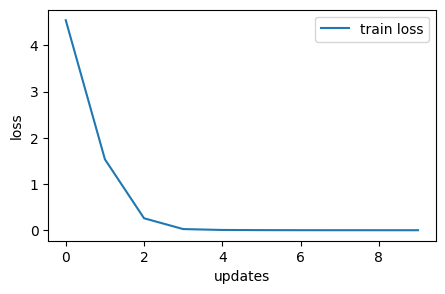

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
# ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

# Open-AI Library

In [40]:
# !pip install -U openai-whisper
# !pip install torchaudio
# !pip install jiwer

## Loading the LibriSpeech dataset

The following will load the test-clean split of the LibriSpeech corpus using torchaudio.

In [41]:
import os
import numpy as np

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=device):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return (mel, text)

In [43]:
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [44]:
import whisper

model = whisper.load_model("tiny")
result = model.transcribe("audio.mp3")
print(result["text"])

/home/todsavadt/.local/lib/python3.10/site-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


 Help me in here! Help me in here!


## Running inference on the dataset using a base Whisper model

The following will take a few minutes to transcribe all utterances in the dataset.

In [45]:
model = whisper.load_model("tiny")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 37,184,640 parameters.


/home/todsavadt/.local/lib/python3.10/site-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [46]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True)

In [47]:
hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)
    break

  0%|          | 0/164 [00:00<?, ?it/s]

In [48]:
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffed into you, his belly, couchled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,"After early nightfall, the yellow lamps would ...",AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hey Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10 Fresh Nelly is waiting on you. Good ...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
5,The music came nearer and he recalled the word...,THE MUSIC CAME NEARER AND HE RECALLED THE WORD...
6,The dull light fell more faintly upon the page...,THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE...
7,A cold lucid indifference rained in his soul.,A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL
8,The chaos in which his order extinguished itse...,THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITS...
9,"At most, by an arms given to a beggar whose bl...",AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLE...


## Calculating the word error rate

Now, we use our English normalizer implementation to standardize the transcription and calculate the WER.

In [49]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [50]:
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffed into you, his belly, couchled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffed into you his belly couchled him,stuff it into you his belly counseled him
2,"After early nightfall, the yellow lamps would ...",AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hey Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hey bertie any good in your mind,hello bertie any good in your mind
4,Number 10 Fresh Nelly is waiting on you. Good ...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
5,The music came nearer and he recalled the word...,THE MUSIC CAME NEARER AND HE RECALLED THE WORD...,the music came nearer and he recalled the word...,the music came nearer and he recalled the word...
6,The dull light fell more faintly upon the page...,THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE...,the dull light fell more faintly upon the page...,the dull light fell more faintly upon the page...
7,A cold lucid indifference rained in his soul.,A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL,a cold lucid indifference rained in his soul,a cold lucid indifference reigned in his soul
8,The chaos in which his order extinguished itse...,THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITS...,the chaos in which his order extinguished itse...,the chaos in which his ardor extinguished itse...
9,"At most, by an arms given to a beggar whose bl...",AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLE...,at most by an arms given to a beggar whose ble...,at most by an alms given to a beggar whose ble...


In [51]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 7.41 %
